# Minerador de dados da CETESB

Danilo Lessa Bernardineli

In [7]:
# Dependências

import pandas as pd
import requests as req
import numpy as np
import json
import time 
from lxml import etree
import threading as th
import os
import pickle as pkl

In [8]:
output_path = "output/"
estacoes_filepath = os.path.join(output_path, "estacoes-cetesb.csv.gz")

## Etapa 0 - exploração livre

Fuçando aleatóriamente pelo site da CETESB, encontrei os seguintes URLs que possibilitam a mineração de dados:

* https://servicos.cetesb.sp.gov.br/arcgis/rest/services/QUALAR/CETESB_QUALAR/MapServer/6/ - WebService que dá informações sobre as estações
* http://sistemasinter.cetesb.sp.gov.br/Ar/php/ar_dados_horarios_resultado.php - Site de consulta pública que permite obter dados de poluentes em qualquer dia e estação

O primeiro link fornece informações como ID, nome, endereço e coordenadas das estações, os quais podem ser usados como input no segundo URL para adquirir os dados dos poluentes

## Etapa 1 - Obter informações das estações

In [3]:
#URI do WebService
URI_estacoes = "https://servicos.cetesb.sp.gov.br/arcgis/rest/services/QUALAR/CETESB_QUALAR/MapServer/6/query"

In [4]:
# IDs das estações
objectIds = np.arange(1, 100)
objectIds = ["{}".format(i) for i in objectIds]
objectIds = ", ".join(objectIds)

In [5]:
# Jogar o pedido para o site
params = {"f": "json", "returnGeometry": "true",
          "outFields": "*", "objectIds": objectIds}
r = req.get(URI_estacoes, params)
json_response = json.loads(r.text)

In [6]:
# Processar os dados e gerar um dataset
dataset_estacoes = []
for feature in json_response["features"]:
    estacao_info = {}
    estacao_info.update(feature["attributes"])
    estacao_info.update(feature["geometry"])
    dataset_estacoes.append(estacao_info)
dataset_estacoes = pd.DataFrame(dataset_estacoes)

In [7]:
# Salvar o resultado
dataset_estacoes.to_csv(estacoes_filepath, compression="gzip", index=False)

# Etapa 2 - Obter correspondência entre as estações

In [8]:
# URL do site com as correspondências
URI_estacoes_2 = "http://sistemasinter.cetesb.sp.gov.br/Ar/php/ar_dados_horarios.php"

In [9]:
r = req.get(URI_estacoes_2)
r.encoding = "utf-8"
raw_html = r.text

In [10]:
tree = etree.HTML(raw_html)
estacoes = tree.xpath("//select/option/@value")

In [11]:
estacoes_id2 = {}
for estacao in estacoes:
    (id2, name) = estacao.split("/")
    estacoes_id2[name] = id2

In [12]:
dataset_estacoes = pd.read_csv(estacoes_filepath, compression="gzip", na_values=["--"])

In [13]:
dataset_estacoes["ID2"] = None
for name, id2 in estacoes_id2.items():
    ind = (dataset_estacoes.Nome == name)
    dataset_estacoes.loc[ind, "ID2"] = id2    
    if (np.sum(ind) == 0):
        print("Não foi possível fazer a correspondência na estação {}".format(name))

ind = ~pd.isnull(dataset_estacoes.ID2)
dataset_estacoes = dataset_estacoes[ind]
dataset_estacoes.to_csv(estacoes_filepath, compression="gzip", index=False)

Não foi possível fazer a correspondência na estação S.José Campos-Vista Verde


## Etapa 3 - Adquirir dados de poluição das estações

In [9]:
# URI do site com dados horários
URI_dados_horarios = "http://sistemasinter.cetesb.sp.gov.br/Ar/php/ar_dados_horarios_resultado.php"
URI_dados_horarios_meteo = "http://sistemasinter.cetesb.sp.gov.br/Ar/php/ar_dados_horarios_Metrl.php"

In [10]:
# Carregar o arquivo com as informações sobre as estações
dataset_estacoes = pd.read_csv(estacoes_filepath, compression="gzip", na_values=["--"])

In [11]:
# Parâmetros livres
inds = (dataset_estacoes.Municipio == "SAO PAULO")
#inds &= (dataset_estacoes.Nome == "Cerqueira César")
#inds &= (dataset_estacoes.Nome == "Pinheiros")
estacoes_id = dataset_estacoes[inds].ID2.values

date_begin = "2018-04-20"
date_end = "2018-05-31"
date_range = pd.date_range(date_begin, date_end, freq="1d")

In [12]:
save_path = True

def get_pollution_data(estacao_id, date):
    """
    Obtém a poluição na estação e data fornecidos
    """
    date_string = "{day:02d}/{month:02d}/{year:04d}".format(year=date.year, month=date.month, day=date.day)
    params = {"texData": date_string, "selEst": estacao_id}
    r = req.post(URI_dados_horarios, params)
    raw_html = r.text
    if (save_path == True):
        pathfile = os.path.join(output_path, "dump/{}_{}.html".format(estacao_id, date.date()))
        with open(pathfile, "w")as fid:
            fid.write(raw_html)
    return raw_html


def get_pollution_block(block, nothing):
    for datapoint in block:
        worked_datapoints.append(datapoint)
        try:
            dataset = get_pollution_data(*datapoint)
            ready_datapoints.append(datapoint)
        except:
            error_datapoints.append(datapoint)
            time.sleep(30)
            continue
            

def generate_blocks(N_threads, datapoints):
    N = len(datapoints)
    block_base_size = int(np.floor(N / N_threads))
    block_reminder = int(N % N_threads)
    j = 0
    blocks = N_threads * [[]]

    for i in range(N_threads):
        if (block_reminder == 0):
            start = i * block_base_size + j
            end = (i + 1) * block_base_size + j
            blocks[i] = datapoints[start:end]
        else:
            start = i * block_base_size + j
            end = (i + 1) * block_base_size + (j + 1)
            blocks[i] = datapoints[start:end]
            j += 1
            block_reminder -= 1
    return blocks

In [13]:
N_threads = 10
datapoints = [[estacao_id, date] for estacao_id in estacoes_id for date in date_range]
blocks = generate_blocks(N_threads, datapoints)

In [14]:
ready_datapoints = []
error_datapoints = []
worked_datapoints = []
global_dataset = []

def work_blocks(blocks):
    for block in blocks:
        th.Thread(target=get_pollution_block, args=(block, 0)).start()

---

Execução da primeira iteração dos blocos aqui

-----

In [15]:
work_blocks(blocks)

In [30]:
worked = len(worked_datapoints) / len(datapoints) * 100
done = len(ready_datapoints) / len(datapoints) * 100
error = len(error_datapoints) / len(datapoints) * 100
tot = len(global_dataset) / len(datapoints) * 100
print("Worked: {:.1f}%\tDone: {:.1f}%\tError: {:.1f}%\tTotal:{:.1f}%".format(worked, done, error, tot))

Worked: 31.4%	Done: 24.4%	Error: 5.6%	Total:0.0%


----------------

Reiterar até minerar tudo

------------------

In [22]:
N_threads = 1
N = len(error_datapoints)
error_blocks = generate_blocks(N_threads, error_datapoints)
ready_datapoints = []
error_datapoints = []
worked_datapoints = []
work_blocks(error_blocks)

In [42]:
worked = len(worked_datapoints) / N * 100
done = len(ready_datapoints) / N * 100
error = len(error_datapoints) / N * 100
tot = len(global_dataset) / N * 100
print("Worked: {:.3f}%\tDone: {:.3f}%\tError: {:.3f}%\tTotal:{:.3f}%".format(worked, done, error, tot))

Worked: 9.664%	Done: 9.804%	Error: 0.000%	Total:0.000%


## Etapa 4 - Interpretar o dump

In [22]:
def parse_pollution_data(raw_html, estacao_id, date):
    html_tables = pd.read_html(raw_html)
    html_tables = html_tables[6:-1]
    dataset = {}
    time = [date + pd.Timedelta(hours=h) for h in range(0, 24)]
    dataset["time"] = time
    dataset["id"] = [estacao_id] * 24
    for html_table in html_tables:
        pollutant = html_table[0][0].split(" ")[0]
        dataset[pollutant] = html_table[0][2:].values
    return dataset

In [23]:
dump_path = os.path.join(output_path, "dump/")

files = os.listdir(dump_path)
filepaths = [os.path.join(dump_path, file) for file in files]
estacoes_id = [file.split(".")[0].split("_")[0] for file in files]
dates = [pd.Timestamp(file.split(".")[0].split("_")[1]) for file in files]

In [24]:
general_dataset = []
for i, file in enumerate(files):
    with open(filepaths[i], "r") as fid:
        raw_html = fid.read()
    estacao_id = estacoes_id[i]
    date = dates[i]
    ds = parse_pollution_data(raw_html, estacao_id, date)
    general_dataset.append(ds)
    print("\r{}/{}".format(i, len(files)), end="")

296/297

In [25]:
with open("output.pkl4", "wb") as fid:
    output = pkl.dump(general_dataset, fid)

## Etapa 5 - transformar tudo em algo legível

In [43]:
with open("output.pkl4", "rb") as fid:
    output = pkl.load(fid)

In [44]:
df_list = []
for output_point in output:
    try:
        df = pd.DataFrame(output_point)
        df_list.append(df)
    except:
        print("error")
        continue

error
error


In [51]:
wow = pd.concat(df_list)
wow.to_csv("aff.csv", index=False)
wow = pd.read_csv("aff.csv", na_values=["--"], parse_dates=["time"])

In [52]:
import matplotlib.pyplot as plt

In [55]:
wow.columns

Index(['BENZENO', 'CO', 'MP10', 'MP2.5', 'NO2', 'O3', 'SO2', 'TOLUENO', 'TRS',
       'id', 'time'],
      dtype='object')

In [58]:
col1 = "time"
col2 = "NO2"

inds = ~pd.isnull(wow[col1])
inds &= ~pd.isnull(wow[col2])

x = wow[inds][col1]
y = wow[inds][col2]

In [85]:
z = wow.resample("1d", on="time").mean()

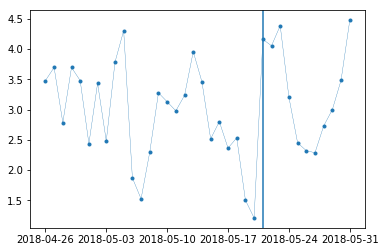

In [89]:
plt.plot(z["SO2"], ".-", linewidth=0.3)
plt.axvline("2018-05-21")
#plt.axvline("2018-05-25")
plt.show()

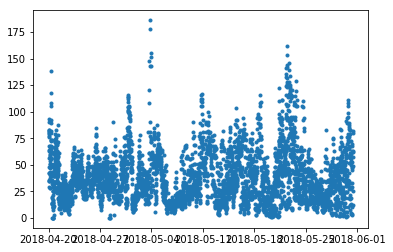

In [59]:
plt.plot(x, y, '.')
plt.show()

In [49]:
y

0     20
1     20
2     24
3     22
4     35
5     21
6     21
7      8
8     28
9     14
10    19
11     6
12    10
13    10
14    19
15    19
16    34
17    34
18    58
19    33
20    31
21    20
22    29
23    21
0     30
1     32
2     27
3     20
4     25
5     24
      ..
18    11
19    14
20    19
21    16
22    23
23    21
0     --
1     --
2     --
3     --
4     --
5     --
6     --
7     --
8     --
9     --
10    --
11    --
12    --
13    --
14    --
15    --
16    --
17    --
18    --
19    --
20    --
21    --
22    --
23    --
Name: MP2.5, Length: 3864, dtype: object